# Data Preparation

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier, plot_importance

In [25]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
test_target = pd.read_csv("Data/test_target.csv")

### Merge von test & train

In [26]:
merged_test = pd.merge(test, test_target, on="PetID", how="left")

In [27]:
combined = pd.concat([train, merged_test], axis=0, ignore_index=True)

### Daten überprüfung

In [28]:
print(train.dtypes)

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object


### Leere Zeilen füllen --> werden als leer gewertet

In [29]:
train.isna().sum()

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

### Spalte Namen löschen

In [30]:
combined = combined.drop(columns=['Name'])

### Vertielungen anschauen

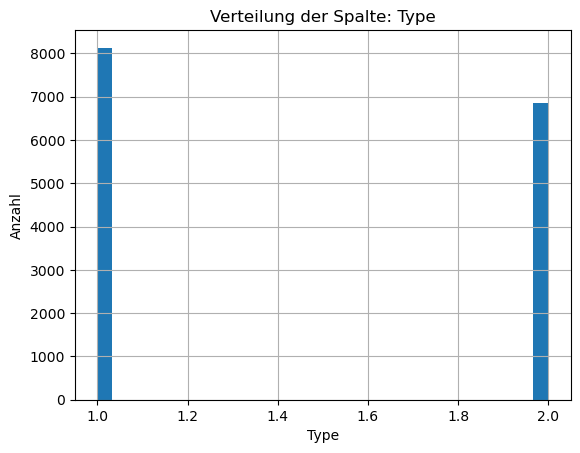

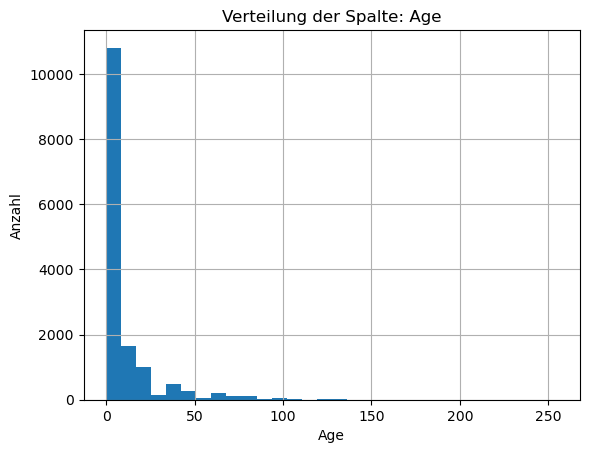

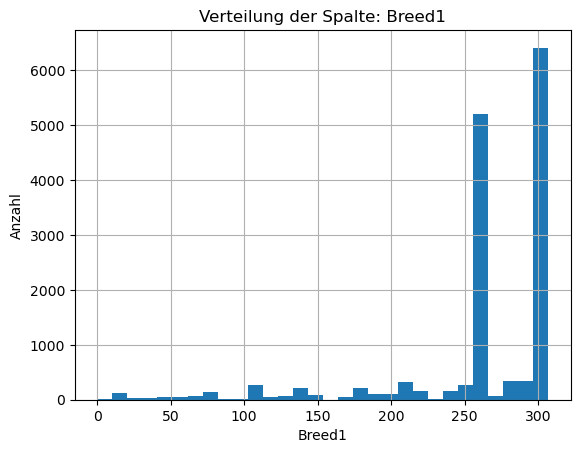

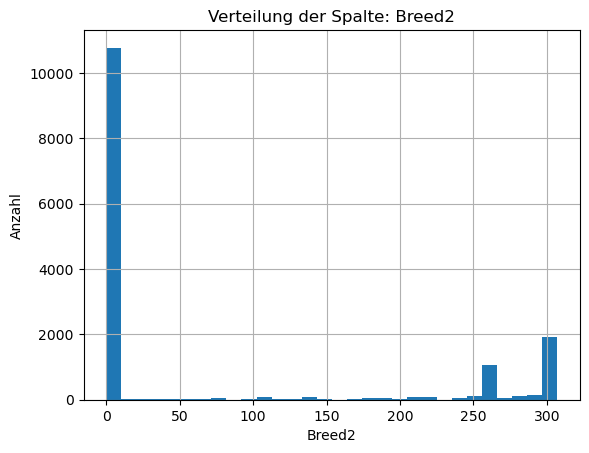

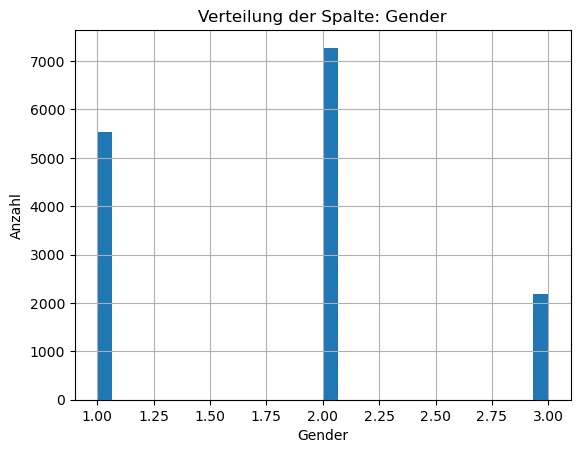

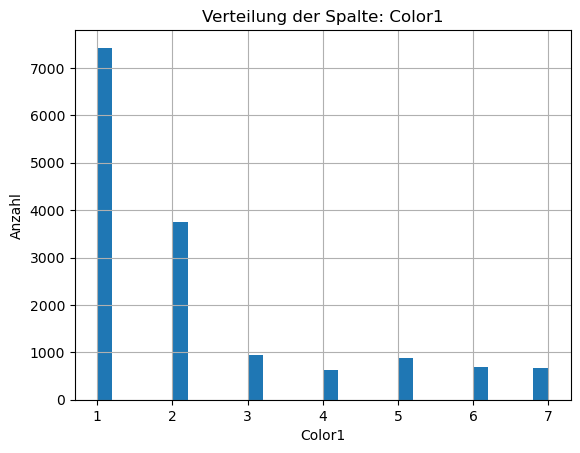

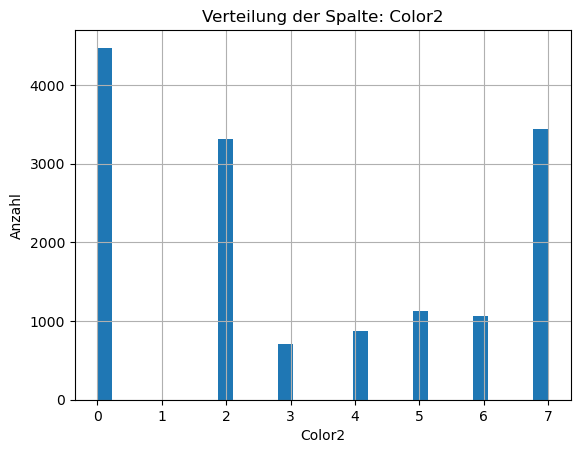

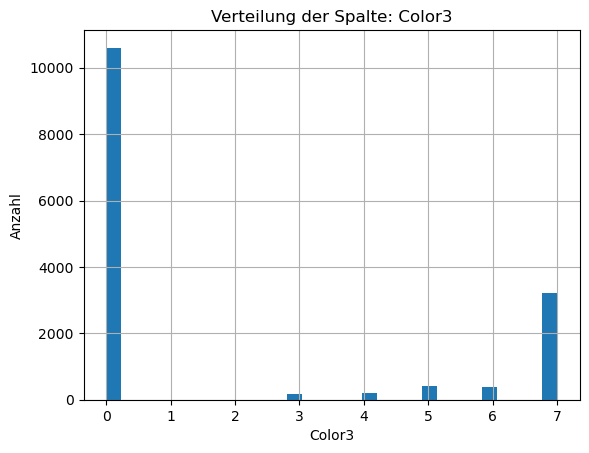

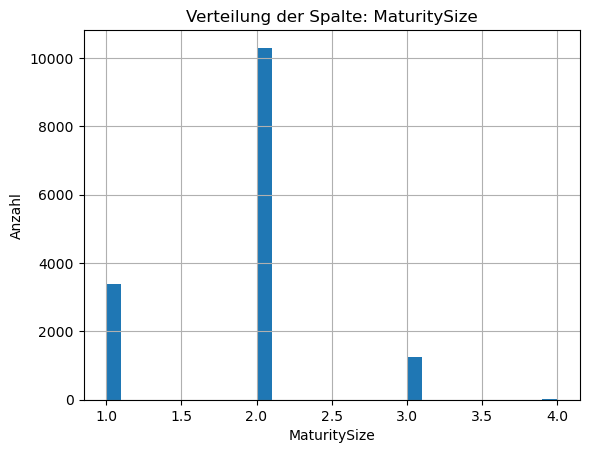

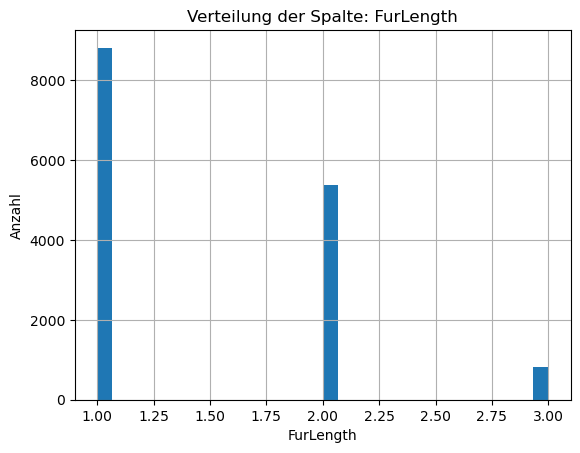

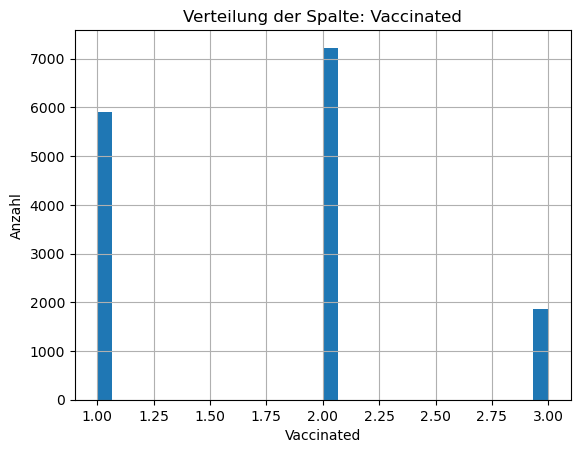

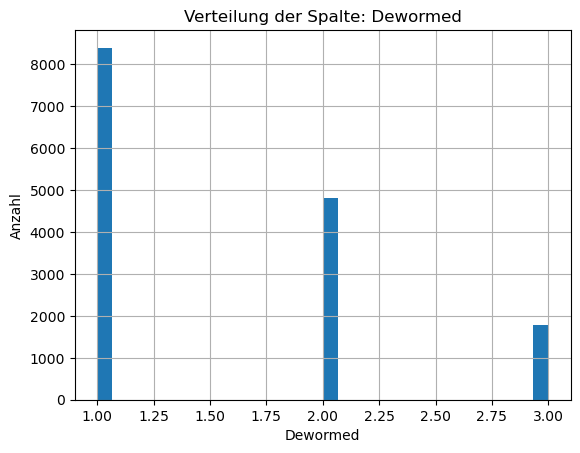

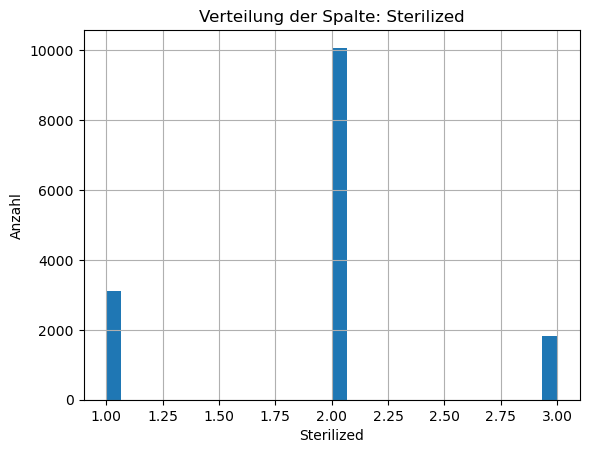

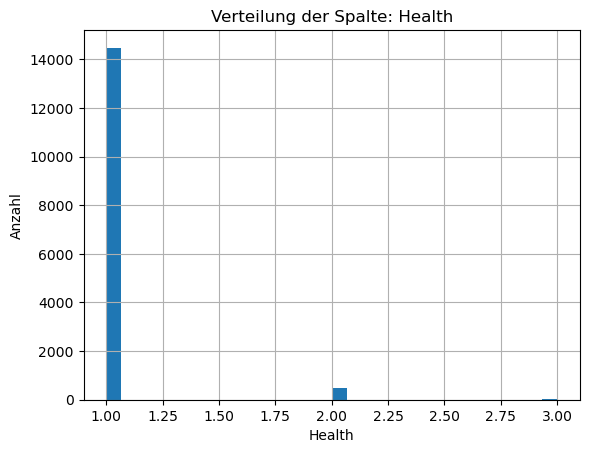

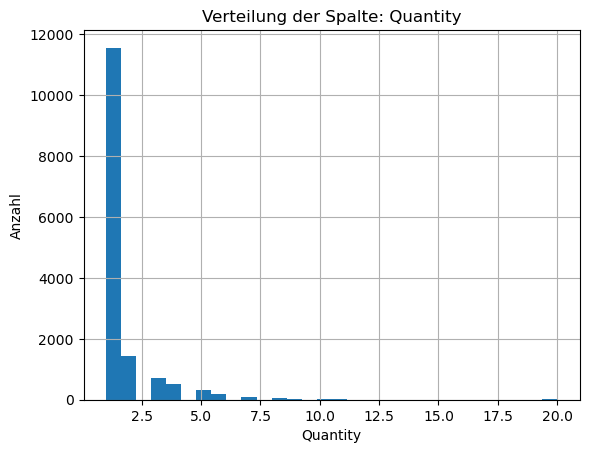

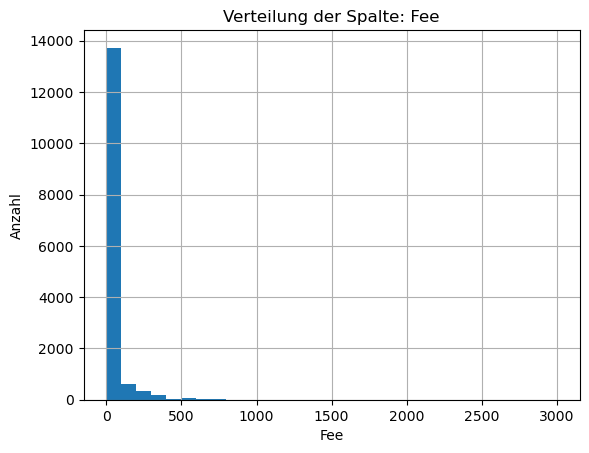

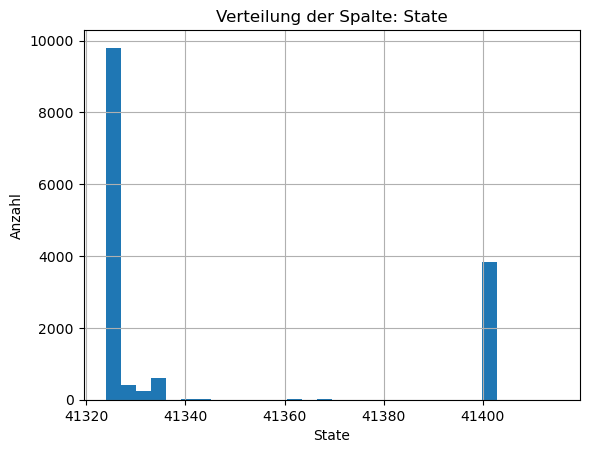

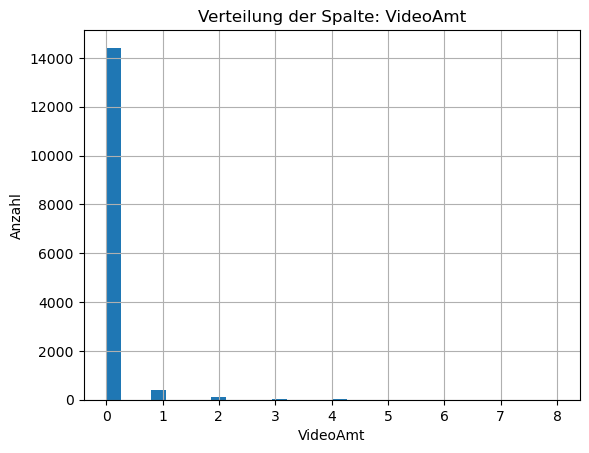

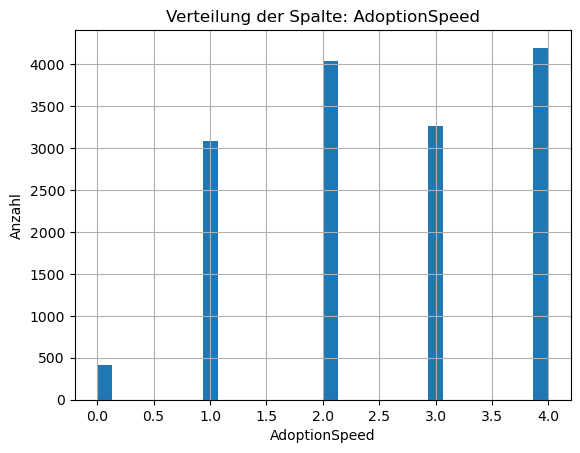

In [31]:
int_columns = combined.select_dtypes(include='int').columns

for col in int_columns:
    plt.figure()
    train[col].hist(bins=30)
    plt.title(f'Verteilung der Spalte: {col}')
    plt.xlabel(col)
    plt.ylabel('Anzahl')
    plt.show()

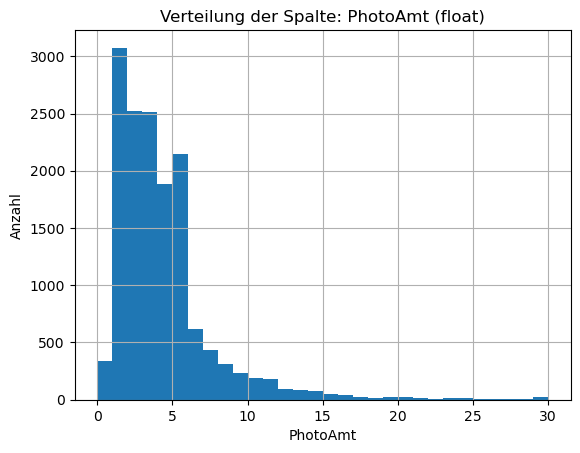

In [32]:
float_columns = combined.select_dtypes(include='float').columns

for col in float_columns:
    plt.figure()
    train[col].hist(bins=30)
    plt.title(f'Verteilung der Spalte: {col} (float)')
    plt.xlabel(col)
    plt.ylabel('Anzahl')
    plt.show()

In [33]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18965 entries, 0 to 18964
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           18965 non-null  int64  
 1   Age            18965 non-null  int64  
 2   Breed1         18965 non-null  int64  
 3   Breed2         18965 non-null  int64  
 4   Gender         18965 non-null  int64  
 5   Color1         18965 non-null  int64  
 6   Color2         18965 non-null  int64  
 7   Color3         18965 non-null  int64  
 8   MaturitySize   18965 non-null  int64  
 9   FurLength      18965 non-null  int64  
 10  Vaccinated     18965 non-null  int64  
 11  Dewormed       18965 non-null  int64  
 12  Sterilized     18965 non-null  int64  
 13  Health         18965 non-null  int64  
 14  Quantity       18965 non-null  int64  
 15  Fee            18965 non-null  int64  
 16  State          18965 non-null  int64  
 17  RescuerID      18965 non-null  object 
 18  VideoA

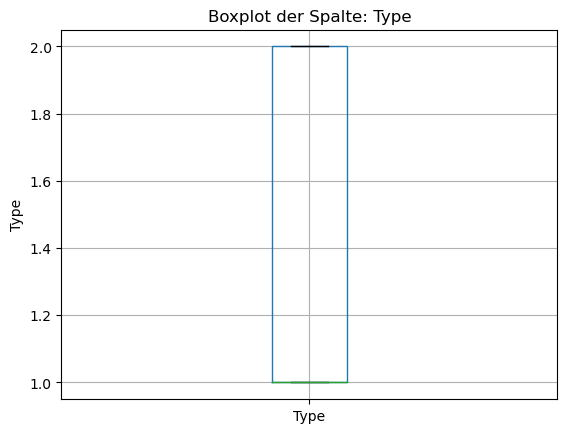

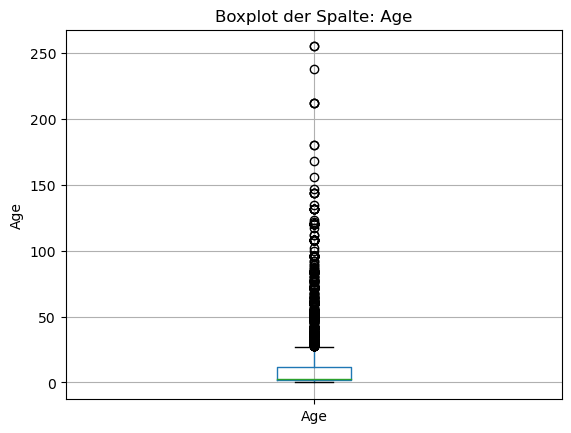

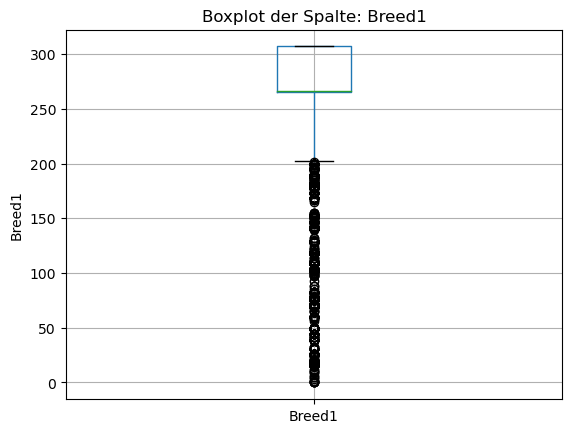

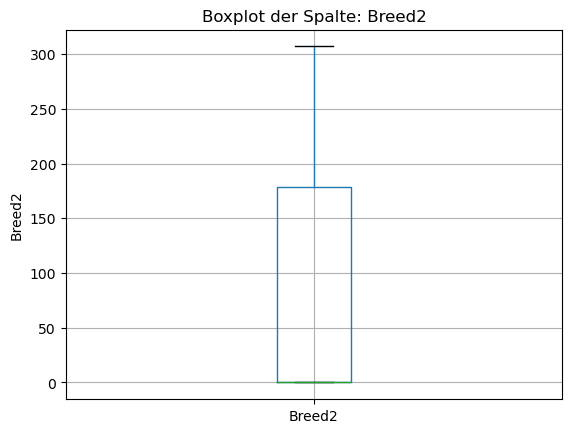

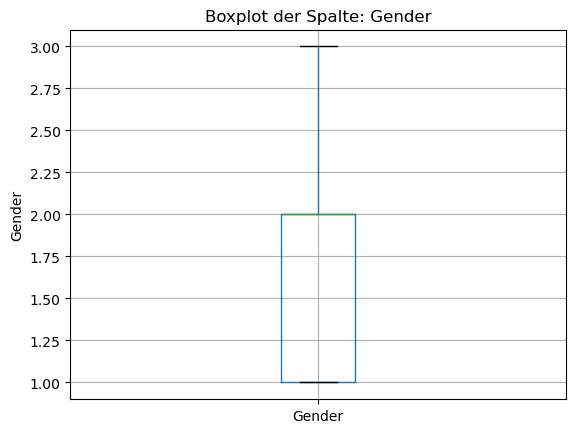

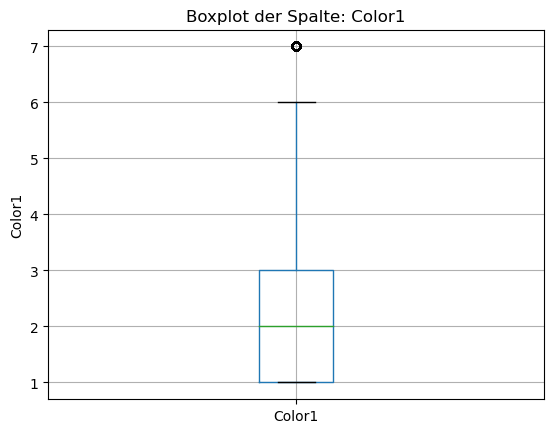

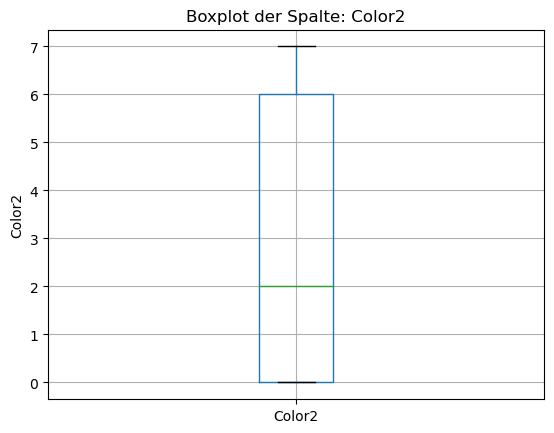

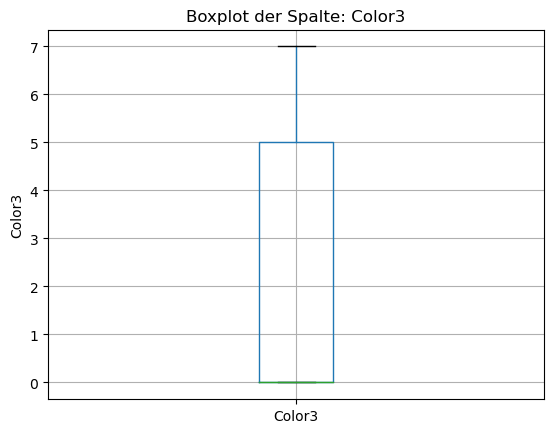

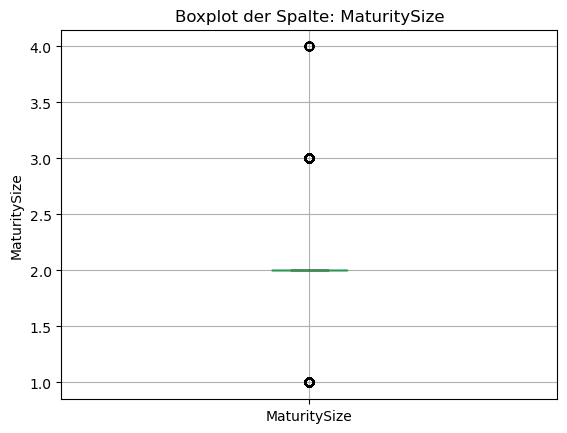

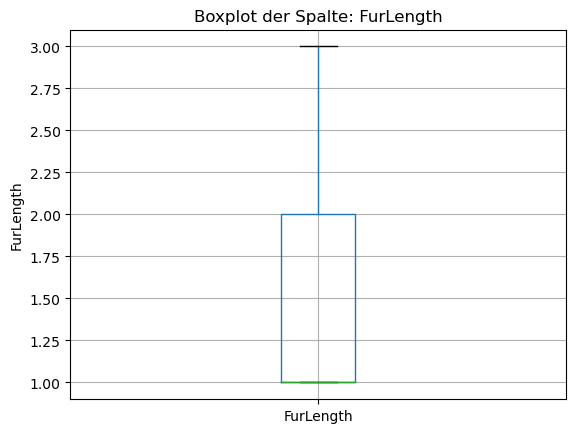

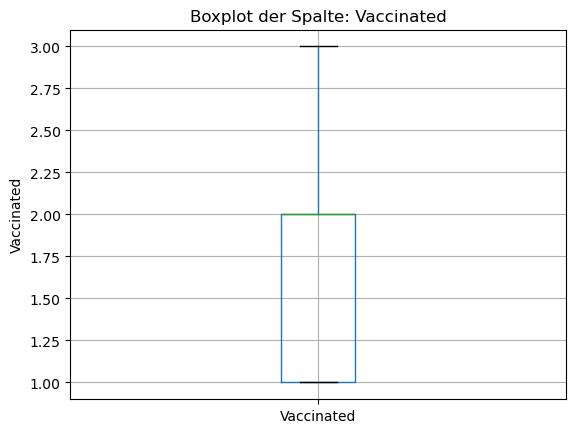

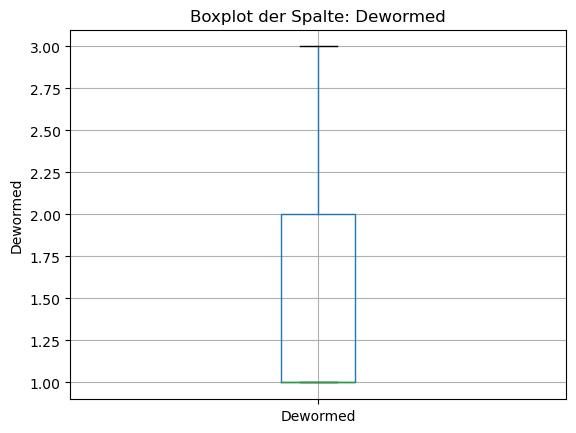

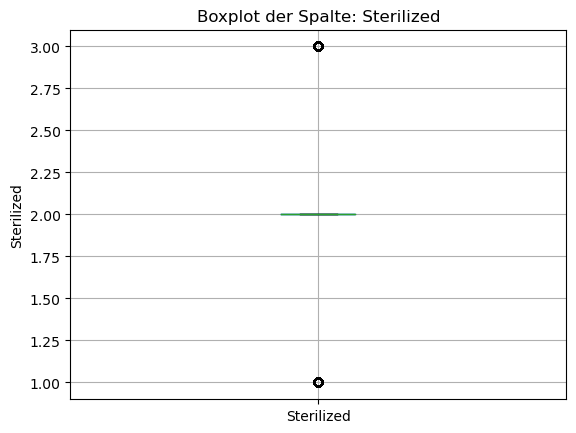

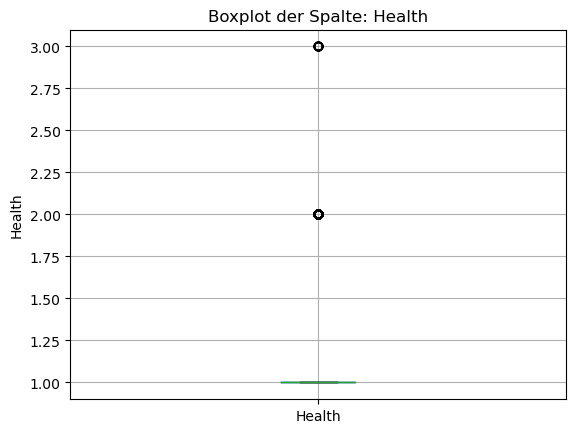

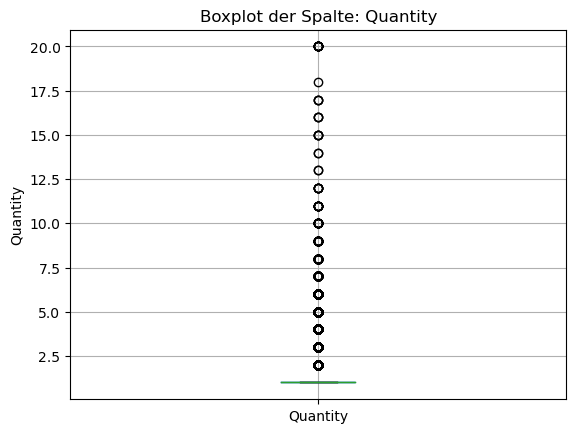

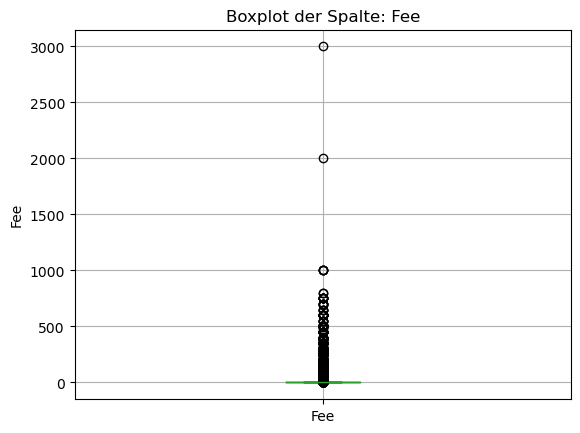

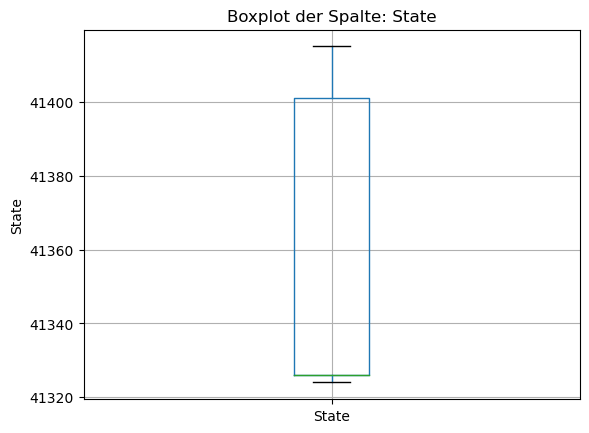

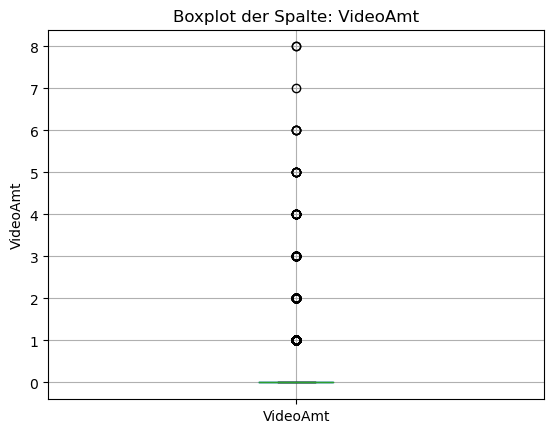

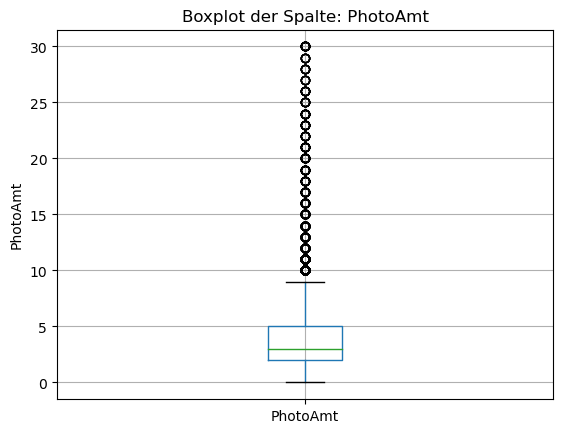

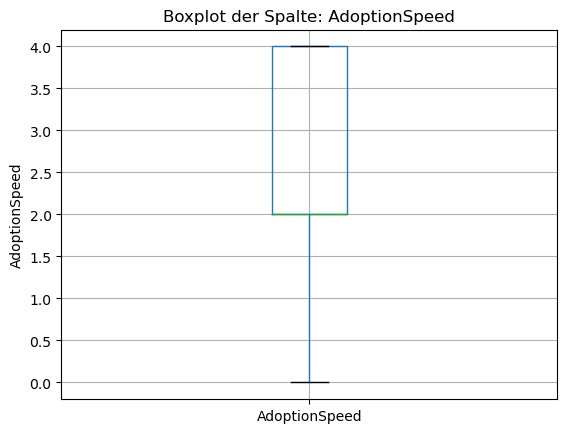

In [34]:
numeric_columns = combined.select_dtypes(include=['int', 'float'])

for col in numeric_columns:
    plt.figure()
    train.boxplot(column=col)
    plt.title(f'Boxplot der Spalte: {col}')
    plt.ylabel(col)
    plt.show()

### Description anpassen im combined df

In [35]:
combined["description_wordcount"] = combined["Description"].fillna("").apply(lambda x: len(x.split()))

In [36]:
print(combined["description_wordcount"].describe())

count    18965.00000
mean        61.95613
std         67.41449
min          0.00000
25%         20.00000
50%         44.00000
75%         80.00000
max       1257.00000
Name: description_wordcount, dtype: float64


In [37]:
combined['description_wordcount']

0        69
1        23
2        69
3        25
4        81
         ..
18960    21
18961    24
18962    34
18963    19
18964     9
Name: description_wordcount, Length: 18965, dtype: int64

In [38]:
combined = combined.drop(columns=['Description'])

In [39]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18965 entries, 0 to 18964
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Type                   18965 non-null  int64  
 1   Age                    18965 non-null  int64  
 2   Breed1                 18965 non-null  int64  
 3   Breed2                 18965 non-null  int64  
 4   Gender                 18965 non-null  int64  
 5   Color1                 18965 non-null  int64  
 6   Color2                 18965 non-null  int64  
 7   Color3                 18965 non-null  int64  
 8   MaturitySize           18965 non-null  int64  
 9   FurLength              18965 non-null  int64  
 10  Vaccinated             18965 non-null  int64  
 11  Dewormed               18965 non-null  int64  
 12  Sterilized             18965 non-null  int64  
 13  Health                 18965 non-null  int64  
 14  Quantity               18965 non-null  int64  
 15  Fe

### Alter in Kategorien umwandeln

In [40]:
# === Alterskategorie erstellen ===
def categorize_age(age_months):
    if age_months <= 6:
        return 'Baby'
    elif age_months <= 12:
        return 'Jungtier'
    elif age_months <= 72:
        return 'Erwachsen'
    else:
        return 'Senior'

# Kategorie-Spalte hinzufügen (als pandas category)
combined['age_category'] = combined['Age'].apply(categorize_age).astype('category')

# Optional: Spalte 'Age' behalten für andere Modelle
# combined['Age'] bleibt bestehen, kann für lineare Modelle oder neuronale Netze genutzt werden

# Info anzeigen
combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18965 entries, 0 to 18964
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Type                   18965 non-null  int64   
 1   Age                    18965 non-null  int64   
 2   Breed1                 18965 non-null  int64   
 3   Breed2                 18965 non-null  int64   
 4   Gender                 18965 non-null  int64   
 5   Color1                 18965 non-null  int64   
 6   Color2                 18965 non-null  int64   
 7   Color3                 18965 non-null  int64   
 8   MaturitySize           18965 non-null  int64   
 9   FurLength              18965 non-null  int64   
 10  Vaccinated             18965 non-null  int64   
 11  Dewormed               18965 non-null  int64   
 12  Sterilized             18965 non-null  int64   
 13  Health                 18965 non-null  int64   
 14  Quantity               18965 non-null 

In [50]:
import pandas as pd

# Kategorien fixieren
age_categories = ['Baby', 'Jungtier', 'Erwachsen', 'Senior']
combined['age_category'] = pd.Categorical(
    combined['Age'].apply(categorize_age),
    categories=age_categories
)


### RescuerID + PetID löschen

In [51]:
combined.drop(columns=['RescuerID'], inplace=True)
combined.drop(columns=['PetID'], inplace=True)

KeyError: "['RescuerID'] not found in axis"

### Df speichern

In [52]:
# Bearbeiteter df speichern
combined.to_csv("Data/preprocessed/combined_preprocessed.csv", index=False)

In [53]:
from sklearn.model_selection import train_test_split

# Erst in train und temp splitten
train_df, temp_df = train_test_split(combined, test_size=0.3, random_state=42)

# Dann temp in valid und test splitten
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Train: 13275, Valid: 2845, Test: 2845


### Test 

c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:29:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.34721856050619565

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.39      0.39       876
           1       0.28      0.27      0.27       618
           2       0.27      0.30      0.29       807
           3       0.31      0.19      0.24       652
           4       0.43      0.52      0.47       840

    accuracy                           0.35      3793
   macro avg       0.34      0.34      0.33      3793
weighted avg       0.34      0.35      0.34      3793



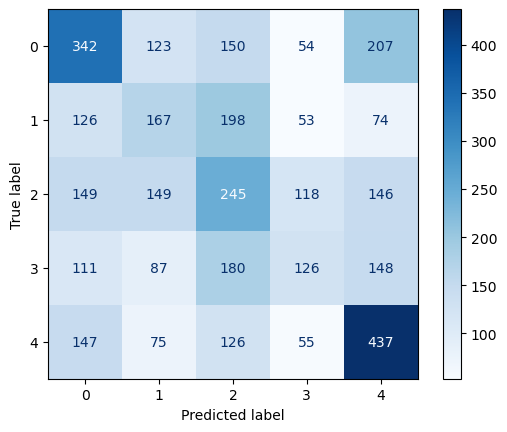

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 1. Features & Ziel ---
X = combined.drop(columns=['AdoptionSpeed'])
y = combined['AdoptionSpeed']

# --- 2. Alle kategorischen Spalten label-encoden ---
for col in X.select_dtypes(include=['category', 'object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# --- 3. Train/Test-Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. XGBoost Modell ---
xgb = XGBClassifier(
    objective="multi:softmax",
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train, y_train)

# --- 5. Vorhersagen ---
y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- 6. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues")


In [57]:
df = pd.read_csv("Data/preprocessed/combined_preprocessed.csv")

X = df.drop(columns=["AdoptionSpeed"])  # Features
y = df["AdoptionSpeed"]

# === 2. Train/Test-Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 3. Label-Verteilung prüfen ===
print("Label-Verteilung:\n", y.value_counts(normalize=True))

# === 4. DummyClassifier (Baseline) ===
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)
print("\nDummy Accuracy:", accuracy_score(y_test, y_dummy))

for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category')
for col in X_test.select_dtypes(include=['object']).columns:
    X_test[col] = X_test[col].astype('category')

# Label-Encoding für XGBoost
X_train['age_category_enc'] = X_train['age_category'].cat.codes
X_test['age_category_enc']  = X_test['age_category'].cat.codes

# Die originale Spalte entfernen für XGBoost
X_train_xgb = X_train.drop(columns=['age_category'])
X_test_xgb  = X_test.drop(columns=['age_category'])

# === 5. XGBoost Modell ===
xgb = XGBClassifier(
    objective="multi:softmax",  # bei binär: "binary:logistic"
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print("\nXGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === 6. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues")
plt.show()

# === 7. Feature Importance ===
plot_importance(xgb, importance_type="weight", max_num_features=15)
plt.show()


Label-Verteilung:
 0    0.231057
4    0.221302
2    0.212866
3    0.171843
1    0.162932
Name: AdoptionSpeed, dtype: float64

Dummy Accuracy: 0.23095175322963354


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:age_category: category

Dummy Accuracy: 0.3332798459563543

Dummy Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50      2077
           1       0.00      0.00      0.00      2077
           2       0.00      0.00      0.00      2078

    accuracy                           0.33      6232
   macro avg       0.11      0.33      0.17      6232
weighted avg       0.11      0.33      0.17      6232



c:\Users\faulh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\faulh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\faulh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\trai


XGBoost Accuracy: 0.6935173299101413

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71      2077
           1       0.65      0.62      0.63      2077
           2       0.70      0.77      0.74      2078

    accuracy                           0.69      6232
   macro avg       0.69      0.69      0.69      6232
weighted avg       0.69      0.69      0.69      6232



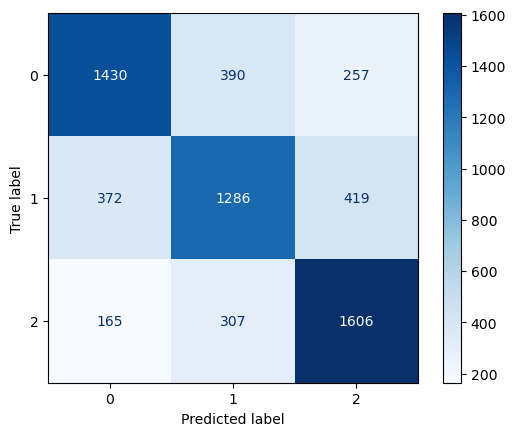

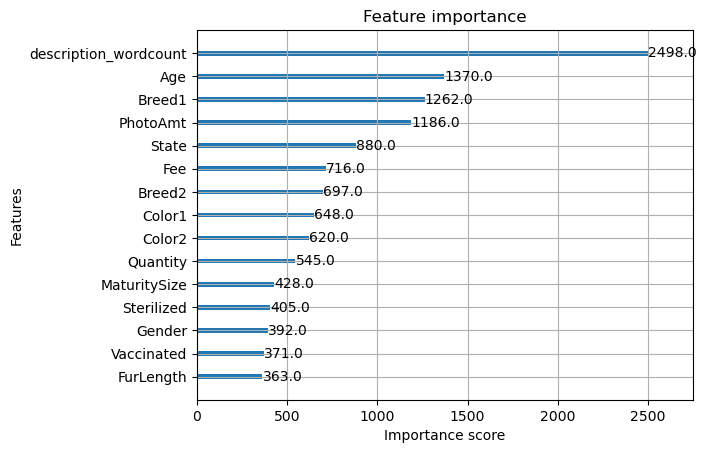

In [60]:
# === 1. Daten vorbereiten ===
df = df.copy()

# Labels von 5 → 3 Klassen mappen
def map_labels(x):
    if x == 0:
        return 0   # sehr schnell adoptiert
    elif x == 4:
        return 2   # gar nicht adoptiert
    else:
        return 1   # mittlere Geschwindigkeiten (1,2,3)

df["target"] = df["AdoptionSpeed"].apply(map_labels)

# Features & Labels trennen
X = df.drop(columns=["AdoptionSpeed", "target"])
y = df["target"]

# Kategorische Variablen umwandeln
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].astype("category")

# === NEU: Zielvariable ausbalancieren ===
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

# === 2. Train/Test-Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# === 3. DummyClassifier (Baseline) ===
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)
print("Dummy Accuracy:", accuracy_score(y_test, y_dummy))
print("\nDummy Classification Report:\n", classification_report(y_test, y_dummy))

# === 4. XGBoost Modell ===
xgb = XGBClassifier(
    objective="multi:softmax",
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    enable_categorical=True
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("\nXGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred))

# === 5. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap="Blues")
plt.show()

# === 6. Feature Importance ===
plot_importance(xgb, importance_type="weight", max_num_features=15)
plt.show()
